# Download Modules

In [1]:
!pip install -q transformers==4.41.2
!pip install -q pyvi
# !pip install -q tf-models-official #==2.7.0
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


# Import Lib

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from wordcloud import WordCloud

# ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib

# DL
import tensorflow as tf
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Embedding, Input, Bidirectional, Dropout, concatenate, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model, Sequential

# PLM
import os
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.data import Dataset
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Read dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
train_df = pd.read_csv("/content/drive/MyDrive/DS108_FP/Final_dataset/train_df.csv")
val_df = pd.read_csv("/content/drive/MyDrive/DS108_FP/Final_dataset/val_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DS108_FP/Final_dataset/test_df.csv")

train_df

,cmt_col,labels
0,cặc,1.0
1,đr hết thời cày rank bk còn ngợp,0.0
2,Diễn viên hô ni hút mà ngại gì mấy khác kk,0.0
3,Toàn bọn vô công rồi nghề ngồi sủa ăn lương th...,2.0
4,lên kim cương bố ỉa vào mồm mày với cái lối lê...,1.0
...,...,...
5161,Đánh ngu đẩy láo chết hét cái đầu buồi,2.0
5162,xinh mà ngu,1.0
5163,Trần ThanhThảo Tuyết Hoa bớt nc vs zai lạ,0.0
5164,Cái tội thích trai đẹp,0.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cmt_col  5166 non-null   object 
 1   labels   5166 non-null   float64
dtypes: float64(1), object(1)
memory usage: 80.8+ KB


# Visualization

In [36]:
# Số lượng từ vựng trong bộ dữ liệu
def statistical(list):
    all_elements = [word for sentence in list for word in sentence.split()]
    unique_set = set(all_elements)
    count_unique = len(unique_set)
    return count_unique

print("Unique words in corpus:", statistical(train_df.cmt_col.tolist() + val_df.cmt_col.tolist() + test_df.cmt_col.tolist()))

Unique words in corpus: 10937


Max sentence len: 133


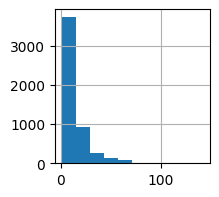

In [37]:
#vẽ biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu.
def visualize(input):
    longest_sentence = max(input.values, key=len)
    print(f"Max sentence len: {len(longest_sentence.split())}")

    ax = plt.figure(figsize=(2,2))
    seq_len = [len(i.split()) for i in input]
    pd.Series(seq_len).hist(bins = 10)
    plt.show()

visualize(train_df.cmt_col)

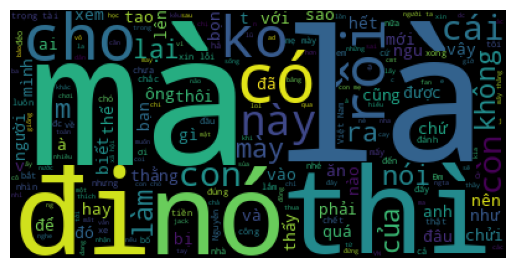

In [38]:
wordcloud2 = WordCloud().generate(' '.join(train_df['cmt_col']))
text3 = ' '.join(train_df['cmt_col'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

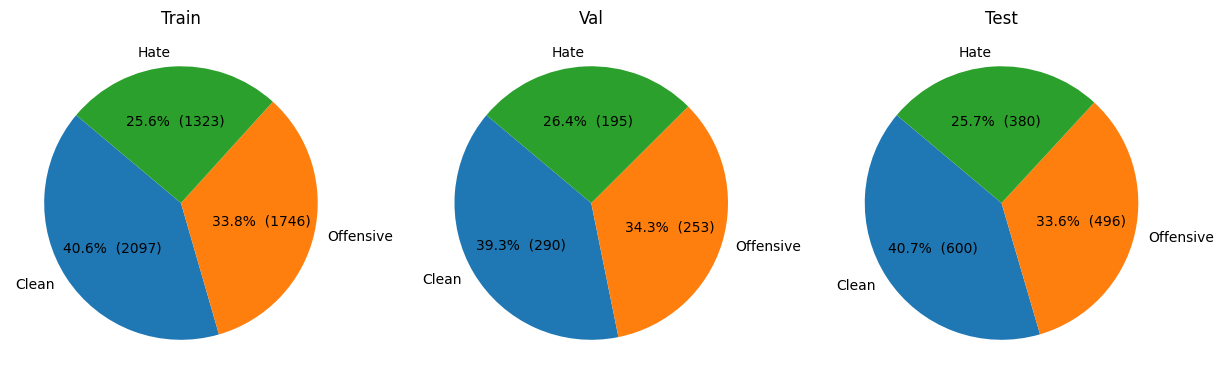

In [25]:
# Số lượng nhãn
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

train_count = Counter(train_df.labels.values)
val_count = Counter(val_df.labels.values)
test_count = Counter(test_df.labels.values)
new_order = [0, 1, 2]
train_count = Counter({key: train_count[key] for key in new_order})
val_count = Counter({key: val_count[key] for key in new_order})
test_count = Counter({key: test_count[key] for key in new_order})

count_list = [train_count, val_count, test_count]
title_list = ["Train", "Val", "Test"]
labels_list = ["Clean", "Offensive", "Hate"]

plt.figure(figsize=(15, 12))
for idx, value in enumerate(count_list):
    plt.subplot2grid((1, 3), (0, idx))
    plt.pie(value.values(), labels = labels_list, autopct=make_autopct(value.values()), explode=[0, 0, 0], startangle=140)
    plt.title(title_list[idx])

# Data Preprocessing

In [ ]:
from preprocess import remove_http, normalize_acronyms, remove_emoji, remove_unnecessary_characters, word_segmentation
def text_preprocess(text):
    text = text.lower()
    text = remove_http(text)
    text = remove_unnecessary_characters(text)
    text = remove_emoji(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text)
    return text

train_text = list(map(text_preprocess, train_df['cmt_col']))
val_text = list(map(text_preprocess, val_df['cmt_col']))
test_text = list(map(text_preprocess, test_df['cmt_col']))

train_labels = train_df.labels.values.astype("int64")
val_labels = val_df.labels.values.astype("int64")
test_labels = test_df.labels.values.astype("int64")

In [ ]:
tfvec = TfidfVectorizer()
train_tf_features = tfvec.fit_transform(train_text)
val_tf_features = tfvec.transform(val_text)
test_tf_features = tfvec.transform(test_text)

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/DS108_FP/data_our/model_save'

# ML

In [ ]:
LR = LogisticRegression()
LR.fit(train_tf_features, train_labels)
pred = LR.predict(test_tf_features)

print(classification_report(pred, test_labels, digits=4))

              precision    recall  f1-score   support

           0     0.8760    0.7580    0.8127       690
           1     0.6133    0.6751    0.6427       437
           2     0.7023    0.8023    0.7490       344

    accuracy                         0.7437      1471
   macro avg     0.7305    0.7451    0.7348      1471
weighted avg     0.7574    0.7437    0.7473      1471



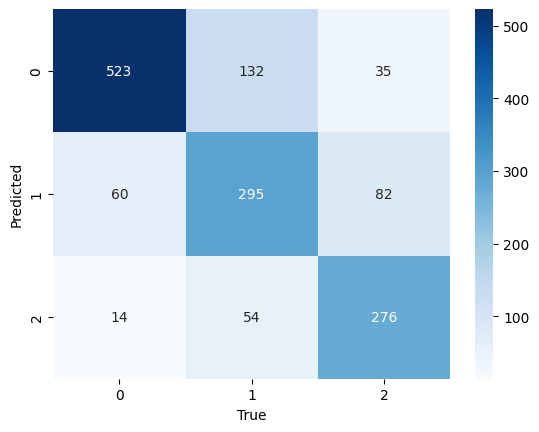

In [ ]:
cf = pd.crosstab(pred, test_labels, rownames=(['Predicted']), colnames=(['True']))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues');

In [ ]:
with open(f'{MODEL_PATH}/lr_74_prep.txt', 'w') as file:
    for item in pred.tolist():
        file.write(f"{item}\n")

In [ ]:
svc = SVC()
svc.fit(train_tf_features, train_labels)
predict = svc.predict(test_tf_features)

print(classification_report(predict, test_labels, digits = 4))

              precision    recall  f1-score   support

           0     0.8961    0.7687    0.8275       696
           1     0.6507    0.7098    0.6790       441
           2     0.6947    0.8174    0.7510       334

    accuracy                         0.7621      1471
   macro avg     0.7472    0.7653    0.7525      1471
weighted avg     0.7768    0.7621    0.7656      1471



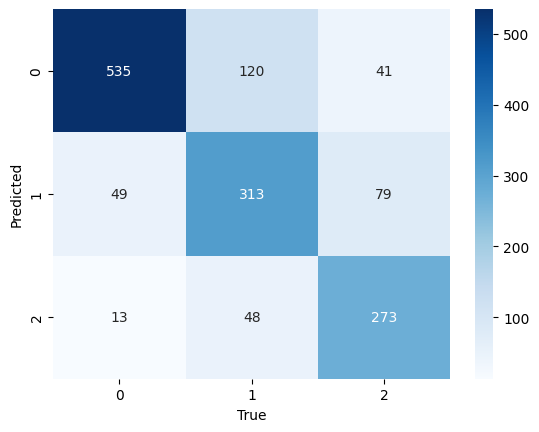

In [ ]:
cf = pd.crosstab(predict, test_labels, rownames=(['Predicted']), colnames=(['True']))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues');

In [ ]:
with open(f'{MODEL_PATH}/svc_76_prep.txt', 'w') as file:
    for item in predict.tolist():
        file.write(f"{item}\n")

In [ ]:
joblib.dump(LR, f'{MODEL_PATH}/LR_74_prep_model.pkl')
joblib.dump(svc, f'{MODEL_PATH}/svc_76_prep_model.pkl')

['/content/drive/MyDrive/DS108_FP/data_our/model_save/svc_76_prep_model.pkl']

# DL

In [ ]:
max_len = 128

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(train_df.cmt_col.values)

word_to_index = word_tokenizer.word_index
word_to_index['pad'] = 0
word_to_index['unk'] = -1
index_to_word = {i: w for w, i in word_to_index.items()}


def encoding(X):
    sentences = []
    for t in X:
        sentences.append(t)
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["pad"])
    return X

X_train_encoded = encoding(train_text)
X_dev_encoded = encoding(val_text)
X_test_encoded = encoding(test_text)

In [ ]:
num_words = len(word_to_index)
embedding_dim = 128
from tensorflow.keras.optimizers import Adam

def create_bilstm_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(num_words, embedding_dim, input_length=max_len)(input_layer)
    bilstm_layer1 = Bidirectional(LSTM(50, dropout=0.2, return_sequences=True))(embedding_layer)
    bilstm_layer2 = Bidirectional(LSTM(32, dropout=0.5, return_sequences=False))(bilstm_layer1)

    output_layer = Dense(3, activation='softmax')(bilstm_layer2)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.002), metrics=['accuracy'])
    return model
model = create_bilstm_model()
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 128, 128)          669824    
                                                                 
 bidirectional_48 (Bidirect  (None, 128, 100)          71600     
 ional)                                                          
                                                                 
 bidirectional_49 (Bidirect  (None, 64)                34048     
 ional)                                                          
                                                                 
 dense_48 (Dense)            (None, 3)                 195       
                                                                 
Total params: 775667 (2.96 MB)
Trainable params: 775667 (2

In [ ]:
his = model.fit(X_train_encoded, to_categorical(train_labels, num_classes=3),
          validation_data = (X_dev_encoded, to_categorical(val_labels, num_classes=3)),
          batch_size=32, epochs = 3
)

Epoch 1/3
162/162 [==============================] - 31s 108ms/step - loss: 0.5022 - accuracy: 0.5960 - val_loss: 0.4220 - val_accuracy: 0.7083
Epoch 2/3
162/162 [==============================] - 8s 51ms/step - loss: 0.3243 - accuracy: 0.7927 - val_loss: 0.3898 - val_accuracy: 0.7558
Epoch 3/3
162/162 [==============================] - 5s 33ms/step - loss: 0.2222 - accuracy: 0.8717 - val_loss: 0.4139 - val_accuracy: 0.7558


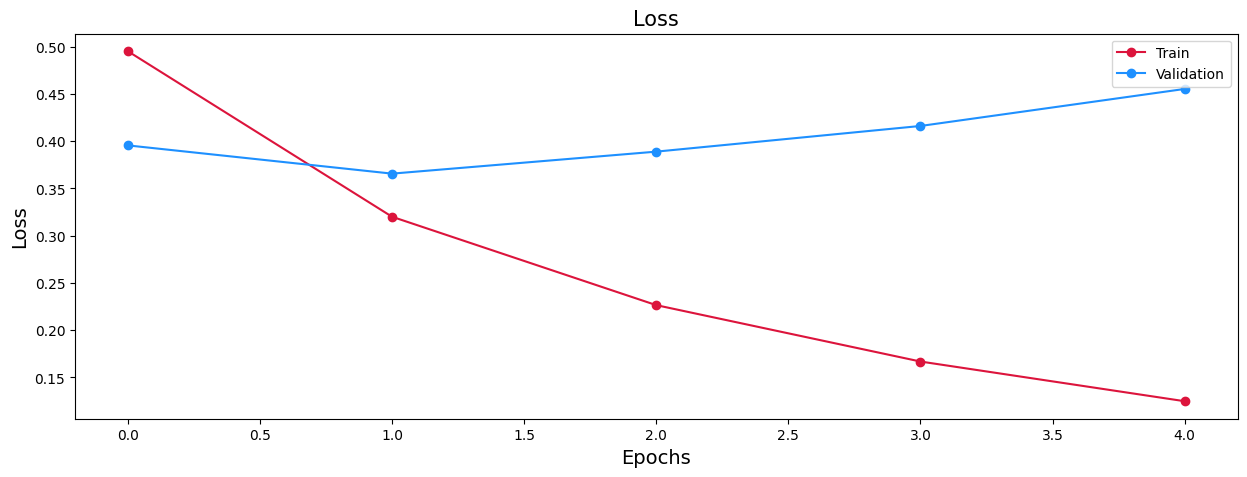

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(his.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(his.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation_DL.png', bbox_inches='tight')
plt.show()

In [ ]:
pred = model.predict(X_test_encoded)
pred = np.argmax(pred, axis = -1)
print(classification_report(pred, test_labels, digits = 4))

46/46 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0     0.8291    0.8278    0.8285       598
           1     0.6694    0.6680    0.6687       482
           2     0.7761    0.7801    0.7781       391

    accuracy                         0.7627      1471
   macro avg     0.7582    0.7586    0.7584      1471
weighted avg     0.7627    0.7627    0.7627      1471



In [ ]:
with open(f'{MODEL_PATH}/BiLSTM_76_prep.txt', 'w') as file:
    for item in pred.tolist():
        file.write(f"{item}\n")

In [ ]:
model.save_weights(f'{MODEL_PATH}/BiLSTM_76_weight.h5')

# PLM

In [39]:
TRAIN_PATH = "/content/drive/MyDrive/DS108_FP/Final_dataset/train_df.csv"
VAL_PATH = "/content/drive/MyDrive/DS108_FP/Final_dataset/val_df.csv"
TEST_PATH = "/content/drive/MyDrive/DS108_FP/Final_dataset/test_df.csv"
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 5166
    })
    val: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 738
    })
    test: Dataset({
        features: ['cmt_col', 'labels'],
        num_rows: 1476
    })
})

In [40]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            labels = df.iloc[row, col]
            if   labels == 0: one_hot = [1, 0, 0] # clean
            elif labels == 1: one_hot = [0, 1, 0] # offensive
            elif labels == 2: one_hot = [0, 0, 1] # hate
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[1]

Train outputs: (5166, 1, 3)
Validate outputs: (738, 1, 3)
Test outputs: (1476, 1, 3)


array([[1, 0, 0]], dtype=uint8)

In [ ]:
PRETRAINED_MODEL = 'uitnlp/visobert'

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

{'xlm-roberta-base': 512,
 'xlm-roberta-large': 512,
 'xlm-roberta-large-finetuned-conll02-dutch': 512,
 'xlm-roberta-large-finetuned-conll02-spanish': 512,
 'xlm-roberta-large-finetuned-conll03-english': 512,
 'xlm-roberta-large-finetuned-conll03-german': 512}

In [ ]:
def tokenize_function(dataset):
    clean_texts = list(dataset['cmt_col'])
    return tokenizer(clean_texts, max_length=256, padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/1471 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 692, 564, 203, 1273, 3611, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
MAX_SEQUENCE_LENGTH = 256
BATCH_SIZE = 18

STEPS_PER_EPOCH = (len(raw_datasets['train']) // BATCH_SIZE)
VALIDATION_STEPS = (len(raw_datasets['val']) // BATCH_SIZE)
EPOCHS = 15

In [ ]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-2]).with_format('tensorflow')

def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.uint8, name=None))>

In [ ]:
def create_model(optimizer):
    inputs = {
        'input_ids'     : tf.keras.layers.Input((256,), dtype='int64', name='input_ids'),
        #'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'),
        'attention_mask': tf.keras.layers.Input((256,), dtype='int64', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True, from_pt=True)
    pretrained_bert.trainable = False
    hidden_states = pretrained_bert(inputs).hidden_states

    pooled_output = hidden_states[-1][:, 0, :]
    x = Dropout(0.2)(pooled_output)

    out_dense = Dense(128, 'relu', name = "out_dense")(x)

    outputs = Dense(
            units = 3,
            activation = 'softmax',
            name = 'output_layer',
            )(out_dense)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])
    return model

optimizer = Adam(learning_rate=2e-3)
type(optimizer)

keras.src.optimizers.adam.Adam

In [ ]:
# Keeps initial learning rate for first 6 epochs decreases it exponentially  after that.
def scheduler(epoch, lr):
    if epoch < 6: return lr
    return lr * tf.math.exp(-0.1)
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates => new_lr = lr * factor.
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.2, verbose=1)

In [ ]:
model = create_model(optimizer)

In [ ]:
history = model.fit(
    train_tf_dataset.repeat(),
    validation_data = val_tf_dataset.repeat(),
    validation_steps = VALIDATION_STEPS,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    callbacks = [
        schedule_lr_callback,
        # reduce_lr_callback,
    ],
    verbose = 1
)

In [ ]:
model.save_weights('/content/drive/MyDrive/DS108_FP/save_model/viso_noprep_80.h5')

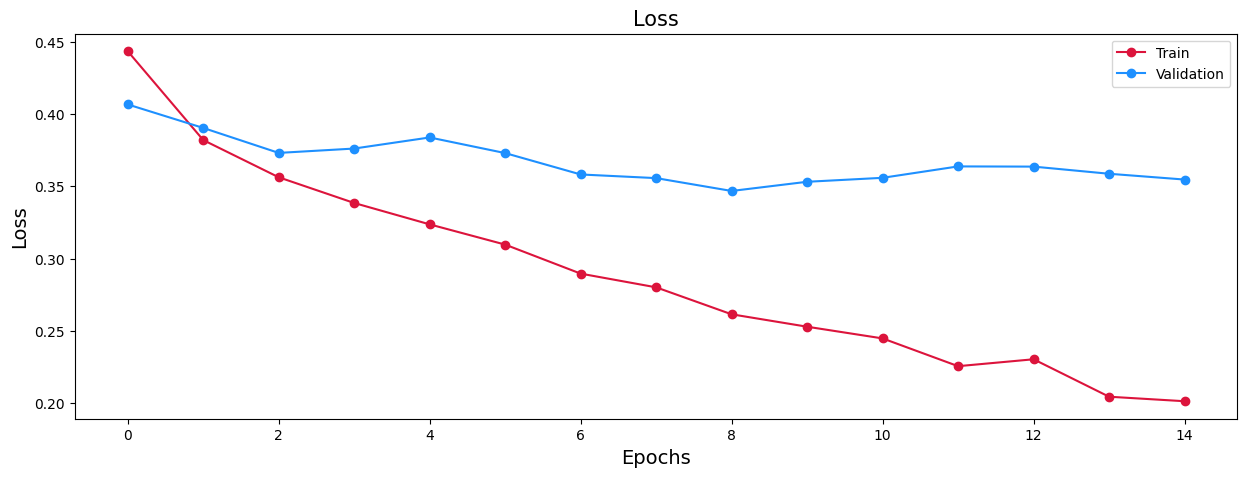

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/viso_noprep.png', bbox_inches='tight')
plt.show()

In [ ]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_pred = model.predict(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
y_pred_arg = np.argmax(y_pred, axis=-1)

# Demo


* Load model

In [ ]:
# ML
reloaded_LR_model = joblib.load(f'{MODEL_PATH}/LR_74_prep_model.pkl')
reloaded_svc_model = joblib.load(f'{MODEL_PATH}/svc_76_prep_model.pkl')
# DL
reloaded_DL_model = create_bilstm_model()
reloaded_DL_model.load_weights(f'{MODEL_PATH}/BiLSTM_76_weight.h5')
# PLM
reloaded_PLM_model = create_model(optimizer)
reloaded_PLM_model.load_weights(f'{MODEL_PATH}/viso_noprep_80.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFXLMRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

* Demo

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def predict(model, input, batch_szie = 1, verbose = 0):
    pred = model.predict(input, batch_size = batch_szie, verbose = verbose)
    pred = np.argmax(pred, axis=-1)
    return pred

def transform_labels(predict):
    if predict == 0:
        return "CLEAN"
    elif predict == 1:
        return "OFFENSIVE"
    else:
        return "HATE SPEECH"


text = input('Enter your sentence: ')
# ML
text_pre = text_preprocess(text)
tf_text = tfvec.transform([text_pre])

LR_pred = reloaded_LR_model.predict(tf_text)
SVM_pred = reloaded_svc_model.predict(tf_text)

# DL
text_pre = text_preprocess(text)
DL_pred = predict(reloaded_DL_model, encoding([text_pre]))

# PLM
text_pre = text
tokenized_input = tokenizer(text_pre, max_length = 256 , padding = 'max_length', truncation = True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

PLM_pred = predict(reloaded_PLM_model, Dataset.from_tensor_slices(features))


print(f"Logistic Regression: {transform_labels(LR_pred)}")
print(f"Support Vector Machine: {transform_labels(SVM_pred)}")
print(f"BiLSTM: {transform_labels(DL_pred)}")
print(f"Visobert: {transform_labels(PLM_pred)}")


Enter your sentence: thằng bê đê không biết nhục à?
Logistic Regression: HATE SPEECH
Support Vector Machine: HATE SPEECH
BiLSTM: OFFENSIVE
Visobert: HATE SPEECH
